In [1]:
import numpy as np
import plotly.graph_objects as go
import plotly.express as ex
from sklearn.decomposition import PCA
import pandas as pd
import scipy
from matplotlib import pyplot as plt

In [2]:
"""
Reading raw data and split it to tokens
"""
with open("zoo.data", 'r') as f:
    raw_data = f.read()

tokens = raw_data.replace("\n", ",").split(",")
tokens = tokens[:-1]

In [3]:
"""
prepare the data and separate them to names, feature vectors and types. For  'number of leg' feature, convert the number to boolean array corresponding [HasNoLeg, HasTwoLegs, ...]
"""
data = {"name":[], "features":[], "type":[]}
for i in range(0, len(tokens), 18):
    data["name"].append(tokens[i])
    
    feature = []
    for j in range(i+1, i+17):
        if not j == i+13:
            feature.append(tokens[j])
        else:
            k = np.ceil(float(tokens[j]) / 2)
    for n in range(6):
        if n == k:
            feature.append(1)
        else: 
            feature.append(0)

    data["features"].append(np.asarray(feature, dtype=np.float32))
    data["type"].append(tokens[i+17])
df = pd.DataFrame(data)



In [4]:
fig = ex.scatter(x=df["name"], y=[np.sum(f) for f in df["features"]], color=df["type"], title="sum of features")
fig.show()

In [5]:
fig = ex.scatter(x=df["name"], y=[np.log2(int("".join(str(int(d)) for d in f), 2)) for f in df["features"]], color=df["type"], title="Log2 features (as binary)")
fig.show()

In [6]:
X = np.asarray([f for f in df["features"]])

## PCA


In [80]:
pca = PCA()
model = pca.fit(X)

In [90]:
ratio = model.explained_variance_ratio_
fig = ex.line(x=np.arange(len(ratio)), y=ratio*100, title="Explained variance ratio")
fig.update_xaxes(title_text='Components')
fig.update_yaxes(title_text='Variance ratio (%)')
fig.show()

In [94]:
pca2 = PCA(n_components=1)
Y = pca2.fit_transform(X)

In [108]:
d = {"names":df["name"], "types":df["type"], "First component":Y.ravel()}
dff = pd.DataFrame(d)
fig = ex.scatter(dff, x="names", y="First component", color="types", title="Mapping data to the first principal component")
fig.show()

In [135]:
pca3 = PCA(n_components=2)
Y = pca3.fit_transform(X)

In [137]:
d = {"names":df["name"], "types":df["type"], "First component":Y[:,0].ravel(), "Second component":Y[:,1].ravel()}
dff = pd.DataFrame(d)
fig = ex.scatter_3d(dff, x="names", y="First component", z="Second component",color="types", title="Mapping data to the first principal component")
fig.show()

## MDS


In [7]:
S = X @ X.T
w, v = scipy.linalg.eigh(S)
w[w<0] = 1e-4
fig = ex.line(x=np.arange(len(w)), y=w, title="Eigen values of S=XX'")
fig.show()

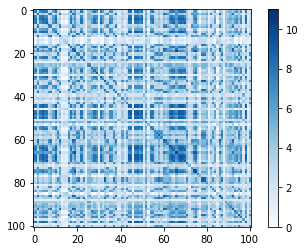

In [327]:
plt.imshow(S, zorder=2, cmap="Blues", interpolation="nearest")
plt.colorbar()

In [8]:
Y = scipy.linalg.sqrtm(np.diag(w))[-1].reshape((1,-1)) @ v.T

In [9]:
d = {"names":df["name"], "types":df["type"], "First component":Y.ravel()}
dff = pd.DataFrame(d)
fig = ex.scatter(dff, x="names", y="First component", color="types", title="MDS on the Gram matrix")
fig.show()

In [12]:
D = np.asarray([np.asarray([(np.sum((x-z)**2)) for z in X]) for x in X])
n = D.shape[0]
J = np.identity(n) - (np.ones((n,n)) / n)
B = -0.5 * J@D@J

In [13]:
w, v = np.linalg.eigh(B)
w[w<0] = 0
Y = scipy.linalg.sqrtm(np.diag(w))[-1].reshape((1,-1)) @ v.T

In [14]:
d = {"names":df["name"], "types":df["type"], "First component":Y.ravel()}
dff = pd.DataFrame(d)
fig = ex.scatter(dff, x="names", y="First component", color="types", title="MDS on the distance matrix")
fig.show()

## ISOMAP


In [22]:
G = np.asarray([np.asarray([np.sum((x-z)**2) for z in X]) for x in X])
# G = scipy.sparse.csr_matrix(G)

In [16]:
D, parents = scipy.sparse.csgraph.shortest_path(csgraph=G, directed=False, return_predecessors=True)

In [17]:
D2 = D*D
n = D2.shape[0]
J = np.identity(n) - (np.ones((n,n)) / n)
B = -0.5 * J@D2@J

In [18]:
w, v = np.linalg.eigh(B)
w[w<0] = 0
Y = scipy.linalg.sqrtm(np.diag(w))[-1].reshape((1,-1)) @ v.T

In [20]:
d = {"names":df["name"], "types":df["type"], "First component":Y.ravel()}
dff = pd.DataFrame(d)
fig = ex.scatter(dff, x="names", y="First component", color="types", title="Full-size neighborhood")
fig.show()

In [23]:
k = 50
graph = np.ones((n,n)) * 1000
for i in range(n):
    dist = np.copy(G[i])
    points = [(j,d) for j, d in zip(np.arange(n), dist)]
    points.sort(reverse=True, key=lambda x:x[1])
    num = 0
    for j,d in points:
        if (d == 0): continue
        graph[i][j] = d
        graph[j][i] = d
        num += 1
        if num == k: break
 

In [24]:
g = scipy.sparse.csr_matrix(graph)
D, parents = scipy.sparse.csgraph.shortest_path(csgraph=g, directed=False, return_predecessors=True)
D2 = D*D
J = np.identity(n) - (np.ones((n,n)) / n)
B = -0.5 * J@D2@J
w, v = np.linalg.eigh(B)
w[w<0] = 0
Y = scipy.linalg.sqrtm(np.diag(w))[-1].reshape((1,-1)) @ v.T

In [25]:
d = {"names":df["name"], "types":df["type"], "First component":Y.ravel()}
dff = pd.DataFrame(d)
fig = ex.scatter(dff, x="names", y="First component", color="types", title="50-neighborhood")
fig.show()

In [26]:
k = 80
graph = np.ones((n,n)) * 1000
for i in range(n):
    dist = np.copy(G[i])
    points = [(j,d) for j, d in zip(np.arange(n), dist)]
    points.sort(reverse=True, key=lambda x:x[1])
    num = 0
    for j,d in points:
        if (d == 0): continue
        graph[i][j] = d
        graph[j][i] = d
        num += 1
        if num == k: break

g = scipy.sparse.csr_matrix(graph)
D, parents = scipy.sparse.csgraph.shortest_path(csgraph=g, directed=False, return_predecessors=True)
D2 = D*D
J = np.identity(n) - (np.ones((n,n)) / n)
B = -0.5 * J@D2@J
w, v = np.linalg.eigh(B)
w[w<0] = 0
Y = scipy.linalg.sqrtm(np.diag(w))[-1].reshape((1,-1)) @ v.T

d = {"names":df["name"], "types":df["type"], "First component":Y.ravel()}
dff = pd.DataFrame(d)
fig = ex.scatter(dff, x="names", y="First component", color="types", title="80-neighborhood")
fig.show()
 

In [27]:
k = 30
graph = np.ones((n,n)) * 1000
for i in range(n):
    dist = np.copy(G[i])
    points = [(j,d) for j, d in zip(np.arange(n), dist)]
    points.sort(reverse=True, key=lambda x:x[1])
    num = 0
    for j,d in points:
        if (d == 0): continue
        graph[i][j] = d
        graph[j][i] = d
        num += 1
        if num == k: break

g = scipy.sparse.csr_matrix(graph)
D, parents = scipy.sparse.csgraph.shortest_path(csgraph=g, directed=False, return_predecessors=True)
D2 = D*D
J = np.identity(n) - (np.ones((n,n)) / n)
B = -0.5 * J@D2@J
w, v = np.linalg.eigh(B)
w[w<0] = 0
Y = scipy.linalg.sqrtm(np.diag(w))[-1].reshape((1,-1)) @ v.T

d = {"names":df["name"], "types":df["type"], "First component":Y.ravel()}
dff = pd.DataFrame(d)
fig = ex.scatter(dff, x="names", y="First component", color="types", title="30-neighborhood")
fig.show()
 